In [ ]:
#MP3.ipynb

#1
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
#2
##parameters
#pump parameters
H_shut_ref = 41.0 #
K_p = 0.010 
N_ref = 1800.0 #rpm rated

#system parameters
H_static = 6.0 #m
K_sys = 0.012 #(m³/h)⁻² units in m³/h

#control pi parameters
Kp = 8.0
Ki = 1.0
dt = 0.1#secs

#speed limits
N_min = 800.0 #rpm
N_max = 1800.0 #rpm

#vfd limit
vfd_ramp_rpm_per_s = 2000.0

#motor parameters
P_base = 15.0 #rated kw

#vfd parameters
poles = 4               
slip = 0.02

#sensor parameters
sensor_bias = 0.2
sensor_noise_std = 0.1
integrator_limit = 5000


In [ ]:
#3
#
def solve_operating_point(N):
    """
    Find Q (m³/h) where pump curve intersects system curve.
    """
    def f(Q):
        H_p = H_shut_ref*(N/N_ref)**2 - K_p*(Q**2)
        H_s = H_static + K_sys*(Q**2)
        return H_p - H_s

    Q_low, Q_high = 0, 150

    if f(Q_high) > 0:    # pump dominates (rare)
        return 0, H_shut_ref*(N/N_ref)**2

    for _ in range(50):
        Q_mid = (Q_low+Q_high)/2
        if f(Q_low)*f(Q_mid) <= 0:
            Q_high = Q_mid
        else:
            Q_low = Q_mid

    Q = (Q_low+Q_high)/2
    H = H_shut_ref*(N/N_ref)**2 - K_p*(Q**2)
    return Q, H


In [ ]:
#4
#PI controller class and VFD functions
class PIController:
    """
    Correct form of PI control:
    N_cmd = Kp*error + Ki*integral
    """
    def __init__(self, Kp, Ki, dt):
        self.Kp = Kp
        self.Ki = Ki
        self.dt = dt
        self.integral = 0

    def step(self, H_sp, H_meas, N_curr):
        err = H_sp - H_meas
        self.integral += err * self.dt
        self.integral = max(min(self.integral, integrator_limit), -integrator_limit)

        # Incremental PI law (assignment spec)
        N_cmd = N_curr + self.Kp*err + self.Ki*self.integral

        # Clamp to limits
        N_cmd = max(min(N_cmd, N_max), N_min)
        return N_cmd, err

def vfd_apply(N_cmd, N_actual):
    max_change = vfd_ramp_rpm_per_s * dt
    delta = N_cmd - N_actual
    if abs(delta) <= max_change:
        return N_cmd
    return N_actual + np.sign(delta)*max_change

def vfd_freq(N):
    return (1-slip)*N*poles/120

def vfd_voltage(freq):
    return (freq/60)*460


In [ ]:
#5

#sim function
def run_sim(duration_s, H_sp_profile, seed=1):
    np.random.seed(seed)

    time = np.arange(0, duration_s+dt, dt)
    controller = PIController(Kp, Ki, dt)

    N = 1200.0
    cumE = 0
    cumV = 0
    log = []

    for t in time:
        H_sp = H_sp_profile(t)
        Q_m3h, H_ideal = solve_operating_point(N)
        H_meas = H_ideal + sensor_bias + np.random.normal(0, sensor_noise_std)
        N_cmd, err = controller.step(H_sp, H_meas, N)
        N = vfd_apply(N_cmd, N)
        P_kW = P_base*(N/N_ref)**3
        Q_m3s = Q_m3h/3600
        cumV += Q_m3s*dt
        cumE += P_kW*(dt/3600)
        SE = cumE/max(cumV,1e-12)
        freq = vfd_freq(N)
        volt = vfd_voltage(freq)

        log.append({
            "t":t, "H_sp":H_sp, "H_meas":H_meas, "H_ideal":H_ideal,
            "Q_m3h":Q_m3h, "N_rpm":N, "N_cmd":N_cmd,
            "P_kW":P_kW, "E_kwh":cumE, "SE_kwh_m3":SE,
            "freq_Hz":freq, "volt_V":volt
        })

    return pd.DataFrame(log)


In [ ]:
#6

#main sim run

def step_profile(t):
    return 25.0 if t < 30 else 15.0

df = run_sim(60, step_profile)
df.head()


,t,H_sp,H_meas,H_ideal,Q_m3h,N_rpm,N_cmd,P_kW,E_kwh,SE_kwh_m3,freq_Hz,volt_V
0,0.0,25.0,13.029101,12.666667,23.570226,1296.964280,1296.964280,5.611226,0.000156,0.238064,42.367500,324.817499
1,0.1,25.0,14.476664,14.337840,26.359439,1383.400388,1383.400388,6.809534,0.000345,0.248765,45.191079,346.464942
2,0.2,25.0,16.084163,15.936980,28.776408,1457.868092,1457.868092,7.969452,0.000566,0.259068,47.623691,365.114964
3,0.3,25.0,17.490103,17.397400,30.818555,1521.839266,1521.839266,9.065257,0.000818,0.268939,49.713416,381.136189
4,0.4,25.0,18.999636,18.713095,32.548803,1574.334212,1574.334212,10.036090,0.001097,0.277966,51.428251,394.283257


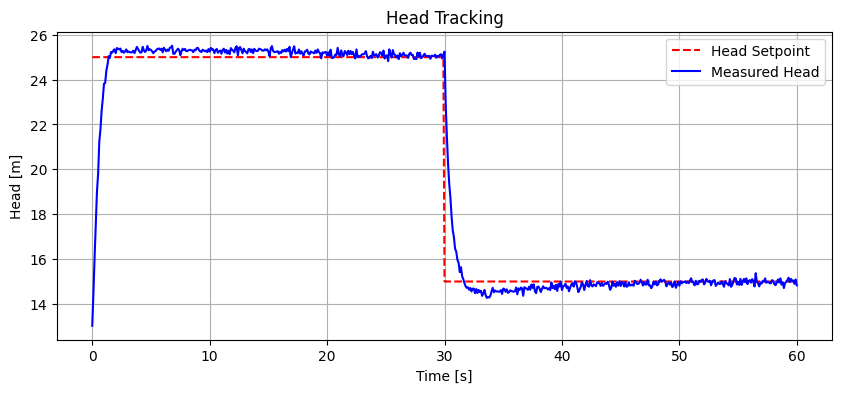

In [7]:
#plot head tracking
plt.figure(figsize=(10,4))
plt.plot(df.t, df.H_sp, 'r--', label='Head Setpoint')
plt.plot(df.t, df.H_meas, 'b-', label='Measured Head')
plt.title("Head Tracking")
plt.xlabel("Time [s]"); plt.ylabel("Head [m]")
plt.grid(); plt.legend()
plt.show()


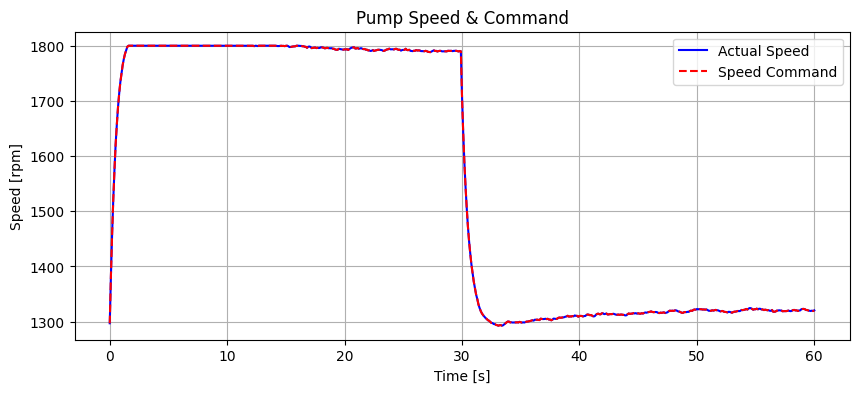

In [8]:
#plot pump speed
plt.figure(figsize=(10,4))
plt.plot(df.t, df.N_rpm, 'b-', label='Actual Speed')
plt.plot(df.t, df.N_cmd, 'r--', label='Speed Command')
plt.title("Pump Speed & Command")
plt.xlabel("Time [s]"); plt.ylabel("Speed [rpm]")
plt.grid(); plt.legend()
plt.show()


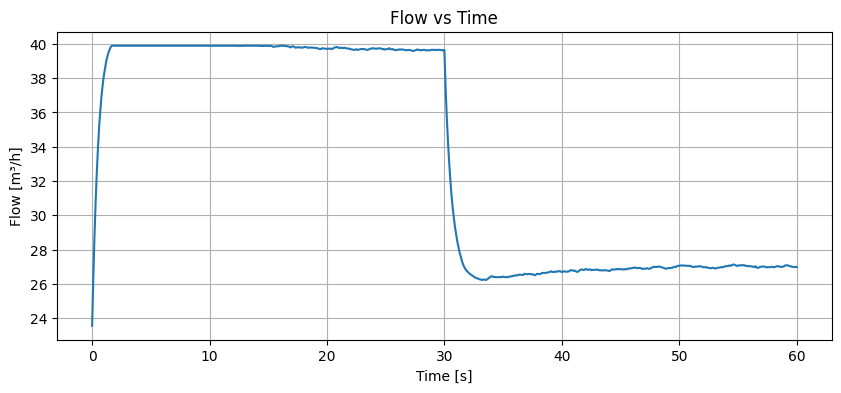

In [9]:
#plot flow
plt.figure(figsize=(10,4))
plt.plot(df.t, df.Q_m3h)
plt.title("Flow vs Time")
plt.xlabel("Time [s]"); plt.ylabel("Flow [m³/h]")
plt.grid()
plt.show()


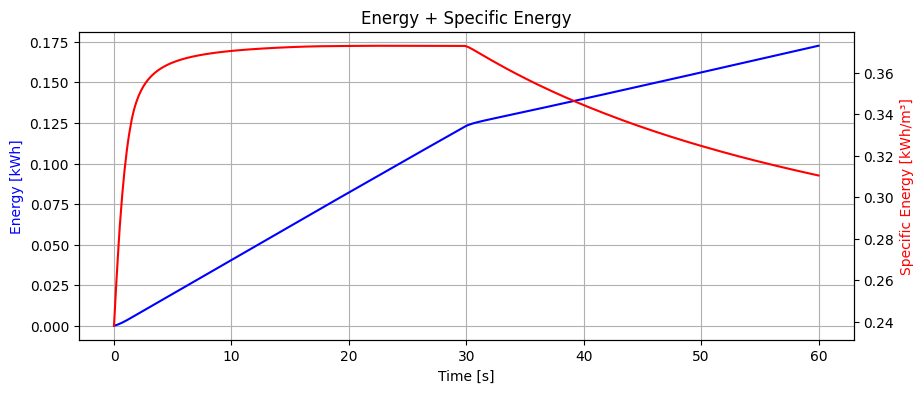

In [10]:
#plot energy and SE
fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()

ax1.plot(df.t, df.E_kwh, 'b-', label="Energy [kWh]")
ax2.plot(df.t, df.SE_kwh_m3, 'r-', label="SE [kWh/m³]")

ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Energy [kWh]", color='b')
ax2.set_ylabel("Specific Energy [kWh/m³]", color='r')
plt.title("Energy + Specific Energy")
ax1.grid()
plt.show()


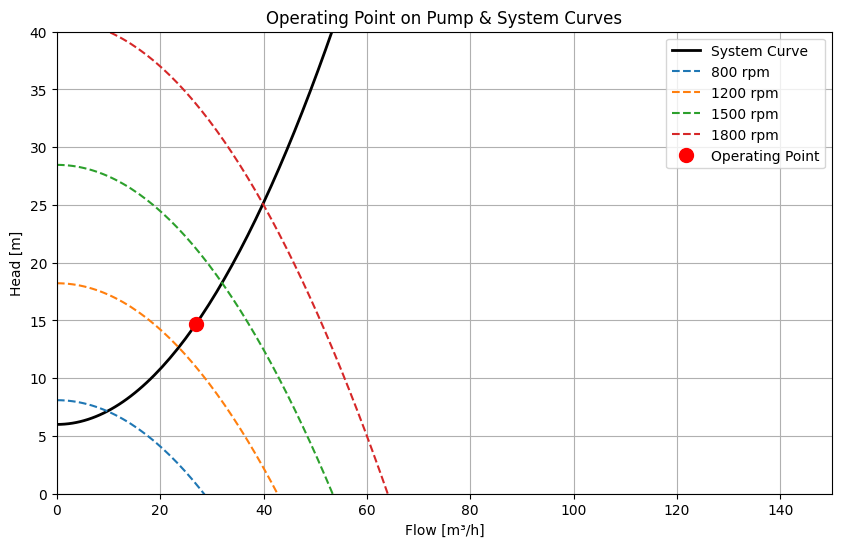

In [11]:
#plot operating point
def plot_operating_point(df):
    Q_range = np.linspace(0,150,200)
    H_sys_curve = H_static + K_sys*(Q_range**2)

    plt.figure(figsize=(10,6))
    plt.plot(Q_range, H_sys_curve, 'k-', linewidth=2, label='System Curve')

    for N in [800,1200,1500,1800]:
        H_p = H_shut_ref*(N/N_ref)**2 - K_p*(Q_range**2)
        plt.plot(Q_range, H_p, '--', label=f'{N} rpm')

    Qf = df.Q_m3h.iloc[-1]
    Hf = df.H_ideal.iloc[-1]

    plt.plot(Qf, Hf, 'ro', markersize=10, label="Operating Point")

    plt.xlim(0,150); plt.ylim(0,40)
    plt.xlabel("Flow [m³/h]"); plt.ylabel("Head [m]")
    plt.title("Operating Point on Pump & System Curves")
    plt.grid(); plt.legend()
    plt.show()

plot_operating_point(df)


In [12]:
#print results of setpoint sweep
print("\n" + "="*70)
print("BASELINE SIMULATION RESULTS (25m → 15m at t=30s)")
print("="*70)

idx_before = np.argmin(np.abs(df.t - 29.9))
idx_after  = df.index[-1]

print(f"Before Step (≈30s):")
print(f"  Speed: {df.iloc[idx_before].N_rpm:.0f} rpm")
print(f"  Flow:  {df.iloc[idx_before].Q_m3h:.1f} m³/h")
print(f"  Power: {df.iloc[idx_before].P_kW:.2f} kW")

print(f"\nAfter Step (60s):")
print(f"  Speed: {df.iloc[idx_after].N_rpm:.0f} rpm")
print(f"  Flow:  {df.iloc[idx_after].Q_m3h:.1f} m³/h")
print(f"  Power: {df.iloc[idx_after].P_kW:.2f} kW")

power_reduction = (1 - df.iloc[idx_after].P_kW/df.iloc[idx_before].P_kW)*100
print(f"\nPower Reduction: {power_reduction:.1f}%")
print("="*70)



BASELINE SIMULATION RESULTS (25m → 15m at t=30s)
Before Step (≈30s):
  Speed: 1790 rpm
  Flow:  39.6 m³/h
  Power: 14.75 kW

After Step (60s):
  Speed: 1320 rpm
  Flow:  27.0 m³/h
  Power: 5.92 kW

Power Reduction: 59.9%


   H_sp          rpm  flow_m3_h   power_kw        SE
0    18  1477.925762  31.329827   8.302934  0.265088
1    20  1572.918207  33.883375  10.009034  0.295671
2    22  1662.492619  36.257620  11.818243  0.326432
3    25  1788.723577  39.559643  14.719852  0.372756
4    28  1800.000000  39.886202  15.000000  0.375373


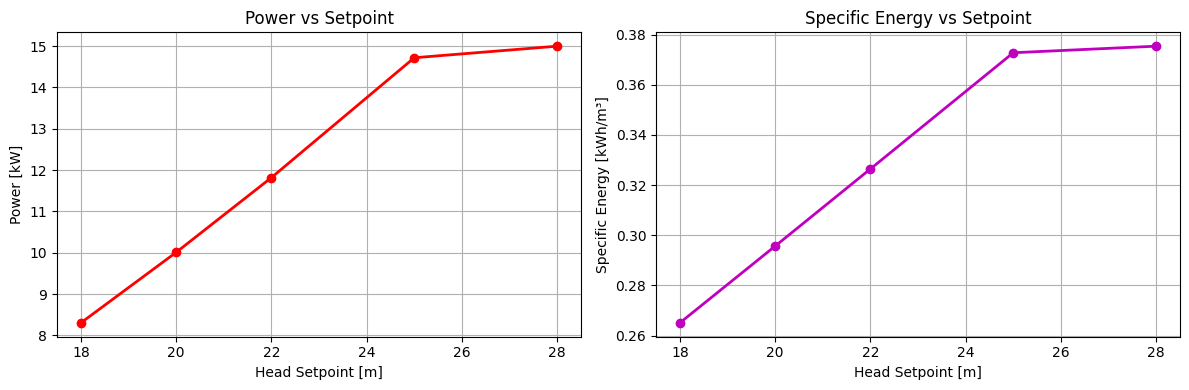

In [ ]:

#sweep head setpoint
sweep_results = []
for H_sp in [18,20,22,25,28]:
    df_s = run_sim(40, lambda t: H_sp)
    final = df_s.iloc[-1]
    sweep_results.append({
        "H_sp": H_sp,
        "rpm": final.N_rpm,
        "flow_m3_h": final.Q_m3h,
        "power_kw": final.P_kW,
        "SE": final.SE_kwh_m3
    })
df_sweep = pd.DataFrame(sweep_results)
print(df_sweep)

#plot sweep results
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(df_sweep.H_sp, df_sweep.power_kw, 'ro-', linewidth=2)
axes[0].set_xlabel("Head Setpoint [m]"); axes[0].set_ylabel("Power [kW]")
axes[0].set_title("Power vs Setpoint"); axes[0].grid(True)
axes[1].plot(df_sweep.H_sp, df_sweep.SE, 'mo-', linewidth=2)
axes[1].set_xlabel("Head Setpoint [m]"); axes[1].set_ylabel("Specific Energy [kWh/m³]")
axes[1].set_title("Specific Energy vs Setpoint"); axes[1].grid(True)
plt.tight_layout(); plt.show()
